In [1]:
import subprocess
import optuna
import random
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from tqdm import tqdm
from typing import Tuple, List
from scipy.signal import resample
import os
import glob
from pathlib import Path
import yaml
from sklearn.metrics import mean_absolute_error as MAE

In [2]:
SEED = 0xDEAD
np.random.seed(SEED)
random.seed(SEED)

In [3]:
def segment_signal(signal, segment_length, step=None, overlap=None, apply_window=True):
    if step is not None:
        segments = [
            signal[i : i + segment_length]
            for i in range(0, len(signal) - segment_length + 1, step)
        ]
    elif overlap is not None:
        step = int(segment_length * (1 - overlap))
        segments = [
            signal[i : i + segment_length]
            for i in range(0, len(signal) - segment_length + 1, step)
        ]
    else:
        raise ValueError("Either 'step' or 'overlap' must be specified.")
    return np.array(segments)


def time_to_freq_transform(data, f_sampling, db=True, cutoff_freq=None):
    if data.ndim != 1:
        raise ValueError(
            f"Input data must be a 1D NumPy array. Got shape {data.shape}."
        )
    n = data.shape[0] 
    yf = np.fft.rfft(data) 
    freqs = np.fft.rfftfreq(n, d=1 / f_sampling) 
    if cutoff_freq is not None:
        mask = freqs < cutoff_freq 
        yf = yf[mask]
        freqs = freqs[mask]
    yf = np.abs(yf)  
    if db:
        eps = np.finfo(float).eps  
        yf = 20 * np.log10(yf + eps)  
    return yf, freqs


def perform_fft_on_segments(
    segments, f_sampling, db=True, cutoff_freq=250, remove_dc=False
):
    segs = segments.copy()
    if remove_dc:
        segs -= segs.mean(axis=1, keepdims=True)
    num_segments, segment_length = segs.shape
    full_freqs = np.fft.rfftfreq(segment_length, d=1 / f_sampling)
    cutoff_mask = full_freqs < cutoff_freq
    fft_output_length = np.sum(cutoff_mask)

    fft_segments = np.zeros((num_segments, fft_output_length))
    for i in range(num_segments):
        fft_segments[i], freqs = time_to_freq_transform(
            segments[i], f_sampling, db=db, cutoff_freq=cutoff_freq
        )
    return fft_segments, freqs

In [4]:
def get_mean_and_std(fft_segments):
    spectrum_mean = np.mean(fft_segments, axis=0)
    spectrum_std = np.std(fft_segments, axis=0)
    return spectrum_mean, spectrum_std


def tight_plots(ax):
    ax.legend(fontsize=9)
    plt.tight_layout()
    plt.show()


def plot_single_segment_with_uncertainty(fft_segments, 
                                         x_values=None, 
                                         max_points=1000, 
                                         n_std=2, 
                                         title="Spectrum with Uncertainty",
                                         axis_labels=None, 
                                         highlight_freqs=None, 
                                         method='closest',
                                         inplace=True):
    spectrum_mean = np.mean(fft_segments, axis=0)
    spectrum_std = np.std(fft_segments, axis=0) * n_std 
    if max_points is not None and len(spectrum_mean) > max_points:
        spectrum_mean = resample(spectrum_mean, max_points)
        spectrum_std = resample(spectrum_std, max_points)
        if x_values is not None:
            if len(x_values.shape) == 1:
                x_values = resample(x_values, max_points)
            else:
                x_values = resample(x_values, max_points)
        else:
            x_values = np.linspace(0, len(spectrum_mean), len(spectrum_mean))
    else:
        if x_values is None:
            x_values = np.linspace(0, len(spectrum_mean), len(spectrum_mean))

    x_label, y_label = axis_labels if axis_labels else ('Frequency, Hz', 'Power, dB')
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(x_values, spectrum_mean, linewidth=2.0, color='blue', label='Mean Spectrum')
    ax.fill_between(
        x_values,
        spectrum_mean - spectrum_std,
        spectrum_mean + spectrum_std,
        color='blue',
        alpha=0.2,
        label=f'Uncertainty (±{n_std} SD)'
    )
    ax.plot(x_values, spectrum_mean - spectrum_std, linewidth=1.0, color='darkblue', linestyle='--')
    ax.plot(x_values, spectrum_mean + spectrum_std, linewidth=1.0, color='darkblue', linestyle='--')
    if highlight_freqs is not None and len(highlight_freqs) > 0:
        for freq in highlight_freqs:
            if method == 'closest':
                closest_idx = np.abs(x_values - freq).argmin()
                ax.scatter(x_values[closest_idx], spectrum_mean[closest_idx], color='red', s=50)
    ax.set_title(title, fontsize=10, fontweight='bold')
    ax.set_xlabel(x_label, fontsize=9)
    ax.set_ylabel(y_label, fontsize=9)
    ax.grid(True, linestyle='--', linewidth=0.5)
    if inplace:
        tight_plots(ax)
    return fig, ax

In [5]:
def create_metadata_df(base_dir: str, state2name: dict | None = None) -> pd.DataFrame:
    csv_pattern = os.path.join(base_dir, "experiment_*", "current", "*", "*", "*.csv")
    csv_files = glob.glob(csv_pattern)
    metadata_list = []
    for file_path in csv_files:
        parts = file_path.split(os.sep)
        try:
            experiment = parts[-5]  
            load_folder = parts[-3] 
            phase = parts[-2] 
            base_id = os.path.splitext(os.path.basename(file_path))[0]
            measurement_id = base_id + f"_{phase}"
        except IndexError as e:
            print(f"File path {file_path} does not match expected structure: {e}")
            continue
        try:
            load_parts = load_folder.split("_")
            if len(load_parts) >= 3:
                state = load_parts[0][0] 
                load_condition = load_parts[-1] 
            else:
                state = None
                load_condition = load_folder
        except Exception as e:
            print(f"Error parsing load folder {load_folder} in file {file_path}: {e}")
            state, load_condition = None, None
        try:
            df = pd.read_csv(file_path, header=0, index_col=0)
        except Exception as e:
            print(f"Error reading file {file_path}: {e}")
            continue
        df = df.dropna(axis=1, how="all")
        num_observations = df.shape[0]
        if state2name is not None:
            try:
                state = state2name[int(state)]
            except KeyError:
                print(f"Fault type {state} not found in mapping.")
                state = None
        meta_entry = {
            "measurement_id": measurement_id,
            "base_id": base_id,
            "experiment": experiment,
            "state": state,
            "load_condition": load_condition,
            "phase": phase,
            "num_observations": num_observations,
            "file_path": file_path,
            "engine_cfg_path": f"dataset/engine_2/engine.yml",
        }
        metadata_list.append(meta_entry)
    if metadata_list:
        metadata_df = pd.DataFrame(metadata_list)
        metadata_df.set_index("measurement_id", inplace=True)
    else:
        metadata_df = pd.DataFrame(
            columns=[
                "experiment",
                "state",
                "load_condition",
                "phase",
                "num_observations",
                "file_path",
                "engine_cfg_path",
            ]
        )
    return metadata_df


def load_measurement(measurement_id: str, metadata_df: pd.DataFrame) -> pd.DataFrame:
    if measurement_id not in metadata_df.index:
        raise KeyError(f"Measurement {measurement_id} not found in metadata.")
    file_path = metadata_df.loc[measurement_id, "file_path"]
    try:
        df = pd.read_csv(file_path, header=0, index_col=0)
    except Exception as e:
        raise Exception(f"Error reading file {file_path}: {e}")
    df = df.dropna(axis=1, how="all")
    df.columns = ["Time", "Current"]
    df.set_index("Time", inplace=True)
    df.sort_index(inplace=True)
    return df


def preprocessing(
    metadata_df: pd.DataFrame,
    out_dir: str,
    segment_length: int,
    step: int,
    f_sampling: int,
    cutoff_freq: int,
    apply_window: bool = False,
    db: bool = True,
) -> Tuple[np.ndarray, pd.DataFrame, np.ndarray]:
    seg_meta_rows: List[dict] = []
    seg_arrays: List[np.ndarray] = []
    for m_id, meta in tqdm(metadata_df.iterrows(),
                           total=len(metadata_df),
                           desc="pre-processing"):
        df = load_measurement(m_id, metadata_df)
        current = df["Current"].dropna().values
        windows = segment_signal(
            current,
            segment_length=segment_length,
            step=step,
            apply_window=apply_window,
        )
        fft_windows, freqs = perform_fft_on_segments(
            windows,
            f_sampling=f_sampling,
            cutoff_freq=cutoff_freq,
            db=db,
        )
        n_segments = fft_windows.shape[0]
        for s_idx in range(n_segments):
            start_t = df.index[s_idx * step]
            end_t   = df.index[s_idx * step + segment_length - 1]
            seg_meta_rows.append({
                "measurement_id": m_id,
                "segment_idx":    s_idx,
                "start_time":     float(start_t),
                "end_time":       float(end_t),
                "state":          meta["state"],
                "binary_label":   0 if meta["state"] == "normal" else 1,
                "multiclass_label": meta["state"],
                "phase":          int(meta["phase"]),
                "load_condition": meta["load_condition"],
                "experiment":     meta["experiment"],
            })
        seg_arrays.append(fft_windows.astype(np.float32))
    segments = np.vstack(seg_arrays) 
    seg_meta_df = (
        pd.DataFrame(seg_meta_rows)
          .set_index(["measurement_id", "segment_idx"])
    )
    os.makedirs(out_dir, exist_ok=True)
    np.save(os.path.join(out_dir, "segments.npy"), segments)
    np.save(os.path.join(out_dir, "freqs.npy"), freqs)
    seg_meta_df.to_csv(os.path.join(out_dir, "segments_metadata.csv"))
    return segments, seg_meta_df, freqs

In [6]:
with open("training_configs/train_engine-2.yml", "r") as f:
    train_params = yaml.safe_load(f)

f_sampling = train_params["processing_parameters"]["f_sampling"]
shift = train_params["processing_parameters"]["shift"]
segment_length = train_params["processing_parameters"]["segment_length"]
cutoff_freq = train_params["processing_parameters"]["cutoff_freq"]
peak_type = train_params["processing_parameters"]["peak_type"]
peak_segment = train_params["processing_parameters"]["peak_segment"]
amplitude_range = tuple(train_params["processing_parameters"]["amplitude_range"])
sigma_range = tuple(train_params["processing_parameters"]["sigma_range"])
noise_factor = train_params["processing_parameters"]["noise_factor"]
num_epochs_binary = train_params["training_parameters"]["num_epochs_binary"]
num_epochs_multi = train_params["training_parameters"]["num_epochs_multi"]
batch_size = train_params["data_parameters"]["batch_size"]
normalization_method = train_params["dataset_parameters"]["normalization_method"]

train_params

{'engineLabel': 'engine_2',
 'task': 'binary',
 'model': 'ResNet',
 'test_run': False,
 'comet_online': False,
 'seed': 42,
 'processing_parameters': {'f_sampling': 4098,
  'shift': 20,
  'segment_length': 10000,
  'cutoff_freq': 250,
  'db': True,
  'peak_type': 'gaussian',
  'peak_segment': 4,
  'amplitude_range': [0.5, 20.0],
  'sigma_range': [0.5, 1.5],
  'noise_factor': 0.0,
  'include_negative_peaks': True,
  'random_peak_position': True,
  'fault_types_to_use': ['inter-turn short circuits', 'rotor bar defect'],
  'loads_to_use': [0, 20, 40, 60, 80, 100],
  'phases_to_use': [1, 2, 3]},
 'model_parameters': {'attention_module': False, 'dropout': 0.2},
 'training_parameters': {'num_epochs_binary': 30,
  'num_epochs_multi': 30,
  'initial_lr': 0.001,
  'patience': 10},
 'data_parameters': {'batch_size': 4096},
 'dataset_parameters': {'batch_size': 4096,
  'normalization_method': 'min-max',
  'normalization_mode': 'global',
  'real_fault_train': 0,
  'test_size': 0.3,
  'val_size': 0

In [7]:
state2name = {
    1: "rotor bar defect",
    2: "normal",
    3: "bearing defect",
    4: "inter-turn short circuits"
}
base_dir = "dataset/engine_2"
path2metadata = os.path.join(base_dir, 'metadata.csv')
if os.path.isfile(path2metadata):
    metadata_df = pd.read_csv(os.path.join(path2metadata))
    metadata_df.set_index('measurement_id', inplace=True)
else:
    metadata_df = create_metadata_df(base_dir, state2name)
    metadata_df.to_csv(path2metadata)
real_df = metadata_df[(metadata_df.state == 'normal') & (metadata_df.load_condition == 100)]
real_df.head()

,base_id,experiment,state,load_condition,phase,num_observations,file_path,engine_cfg_path
measurement_id,,,,,,,,
1727791012_1,1727791012,experiment_1,normal,100,1,16384,./dataset/engine_2/experiment_1/current/2nd_lo...,./dataset/engine_2/engine.yml
1727791211_1,1727791211,experiment_1,normal,100,1,16384,./dataset/engine_2/experiment_1/current/2nd_lo...,./dataset/engine_2/engine.yml
1727790910_1,1727790910,experiment_1,normal,100,1,16384,./dataset/engine_2/experiment_1/current/2nd_lo...,./dataset/engine_2/engine.yml
1727790870_1,1727790870,experiment_1,normal,100,1,16384,./dataset/engine_2/experiment_1/current/2nd_lo...,./dataset/engine_2/engine.yml
1727791170_1,1727791170,experiment_1,normal,100,1,16384,./dataset/engine_2/experiment_1/current/2nd_lo...,./dataset/engine_2/engine.yml


In [8]:
real_seg = {}
real_freqs = {}

real_seg[1], _, real_freqs[1] = preprocessing(real_df[real_df.phase == 1],
                                              'real_data_1',
                                              segment_length=segment_length,
                                              step=shift,
                                              f_sampling=f_sampling,
                                              cutoff_freq=cutoff_freq
                                              )

real_seg[2], _, real_freqs[2] = preprocessing(real_df[real_df.phase == 2],
                                              'real_data_2',
                                              segment_length=segment_length,
                                              step=shift,
                                              f_sampling=f_sampling,
                                              cutoff_freq=cutoff_freq
                                              )

real_seg[3], _, real_freqs[3] = preprocessing(real_df[real_df.phase == 3],
                                              'real_data_3',
                                              segment_length=segment_length,
                                              step=shift,
                                              f_sampling=f_sampling,
                                              cutoff_freq=cutoff_freq
                                              )

pre-processing: 100%|██████████| 21/21 [00:01<00:00, 11.85it/s]


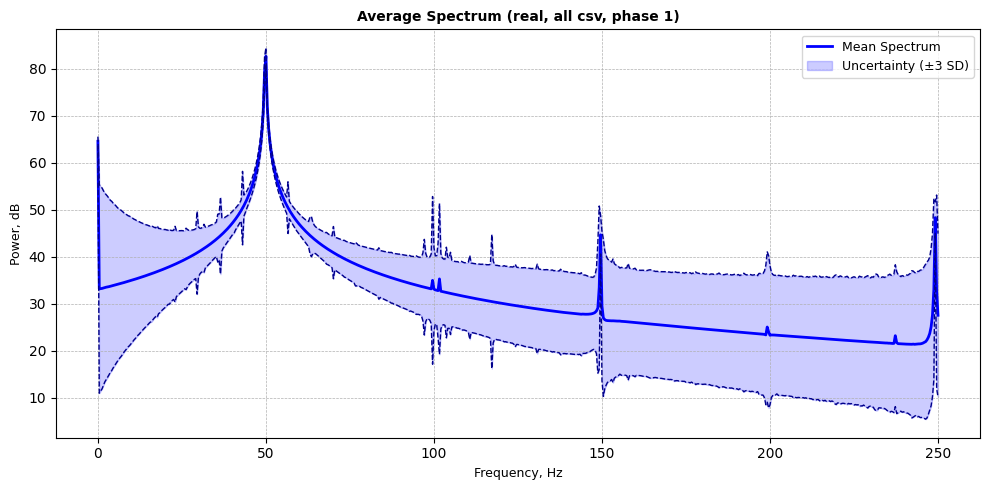

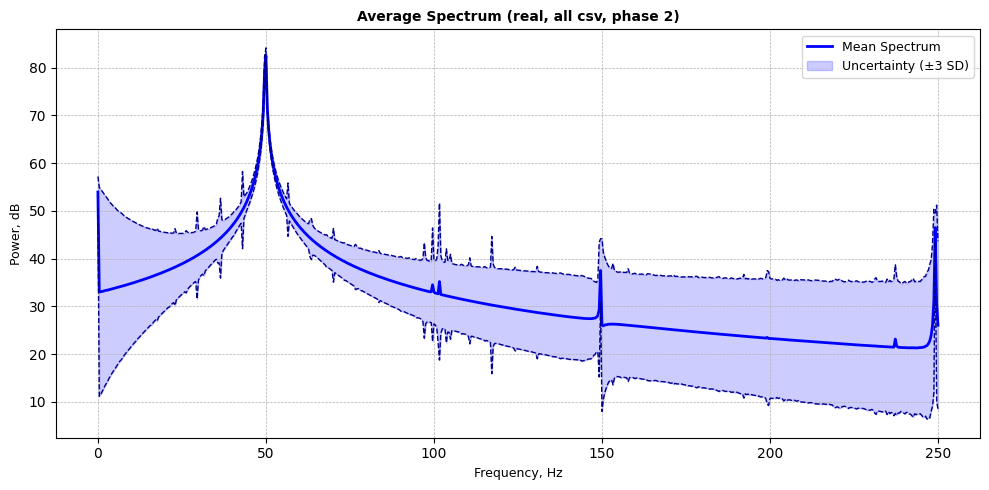

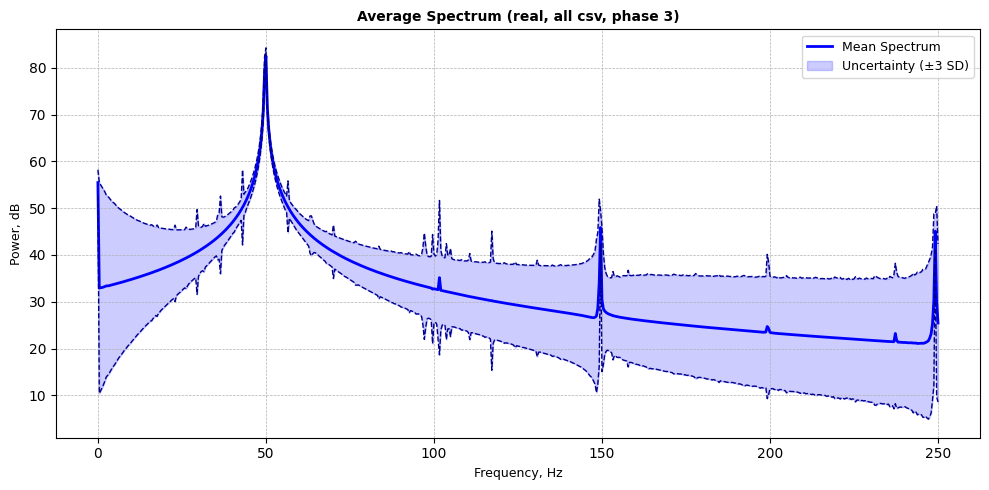

In [9]:
real_means = {}
real_std = {}

for phase in range(1, 4):
    real_means[phase], real_std[phase] = get_mean_and_std(real_seg[phase])
    fig, ax = plot_single_segment_with_uncertainty(real_seg[phase], 
                                                   x_values=real_freqs[phase], 
                                                   n_std=3, 
                                                   title=f'Average Spectrum (real, all csv, phase {phase})',
                                                   inplace=True)

In [ ]:
test_value = 1e-5
subprocess.run(f'matlab -batch "Noizz = {test_value}; Find_Best_Noise_Param"')

CompletedProcess(args='matlab -batch "Noizz = 1e-05; Find_Best_Noise_Param"', returncode=0)

In [ ]:
simulated_files = list(map(str, Path('.\\').glob(f'Noizz{test_value}*.csv')))
simulated_df = pd.DataFrame({'file_path': simulated_files})

def get_phase(x):
    phase = x.split('\\')[-1].split('_')[-1].split('.')[0]
    return 1 if phase == 'phaseA' else 2 if phase == 'phaseB' else 3

def get_num_observations(x):
    return pd.read_csv(x).shape[0]

def get_measurement_id(x):
    return f'{x.state}_{x.phase}'

simulated_df['state'] = 'normal'
simulated_df['load_condition'] = 100
simulated_df['experiment'] = 'experiment_2'
simulated_df['phase'] = simulated_df.file_path.apply(get_phase)
simulated_df['num_observations'] = simulated_df.file_path.apply(get_num_observations)
simulated_df['measurement_id'] = simulated_df.apply(get_measurement_id, axis=1)
simulated_df = simulated_df.reset_index(drop=True).set_index('measurement_id')
simulated_df.head()

,file_path,state,load_condition,experiment,phase,num_observations
measurement_id,,,,,,
normal_1,ConstVal1e-05_load100_phaseA.csv,normal,100,experiment_2,1,16666
normal_2,ConstVal1e-05_load100_phaseB.csv,normal,100,experiment_2,2,16666
normal_3,ConstVal1e-05_load100_phaseC.csv,normal,100,experiment_2,3,16666


In [12]:
sim_seg = {}
sim_freqs = {}

sim_seg[1], _, sim_freqs[1] = preprocessing(simulated_df[simulated_df.phase == 1],
                                            'sim_data_1',
                                            segment_length=segment_length,
                                            step=shift,
                                            f_sampling=f_sampling,
                                            cutoff_freq=cutoff_freq
                                            )

sim_seg[2], _, sim_freqs[2] = preprocessing(simulated_df[simulated_df.phase == 2],
                                            'sim_data_2',
                                            segment_length=segment_length,
                                            step=shift,
                                            f_sampling=f_sampling,
                                            cutoff_freq=cutoff_freq
                                            )

sim_seg[3], _, sim_freqs[3] = preprocessing(simulated_df[simulated_df.phase == 3],
                                            'sim_data_3',
                                            segment_length=segment_length,
                                            step=shift,
                                            f_sampling=f_sampling,
                                            cutoff_freq=cutoff_freq
                                            )

pre-processing: 100%|██████████| 1/1 [00:00<00:00, 13.29it/s]


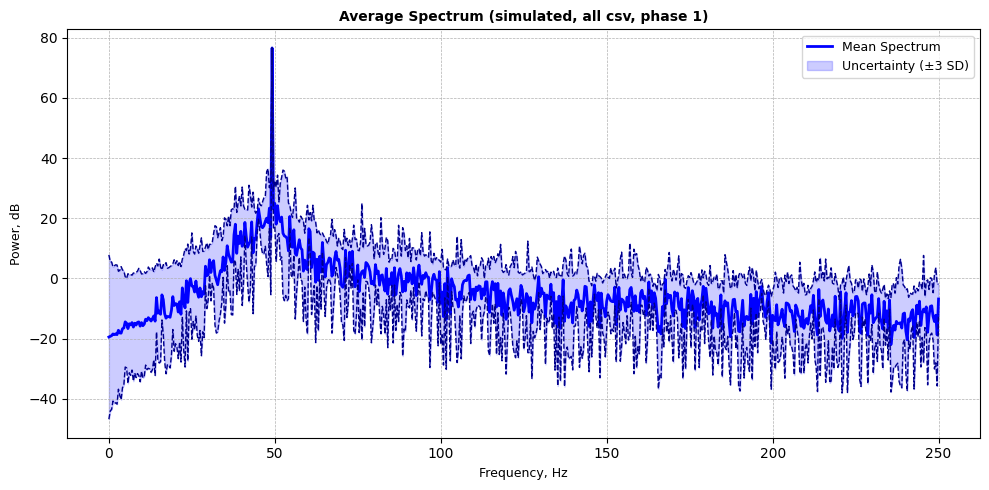

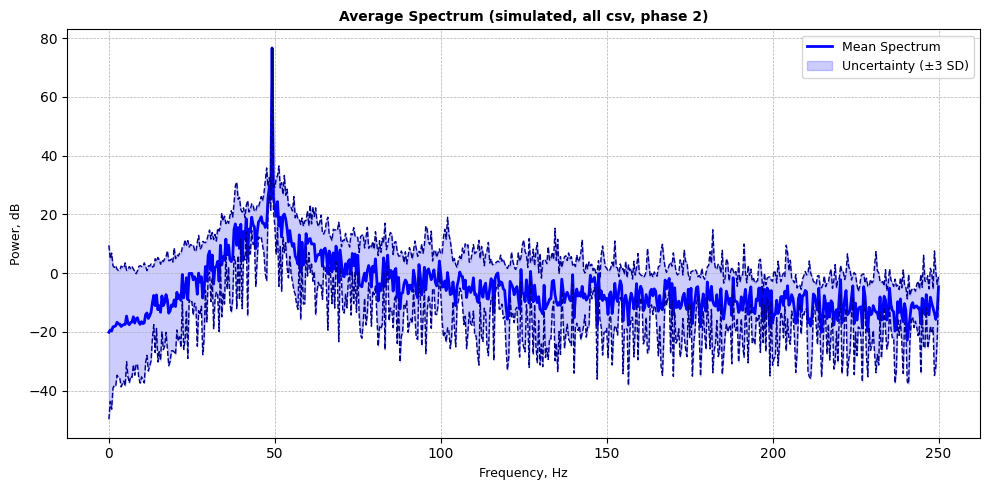

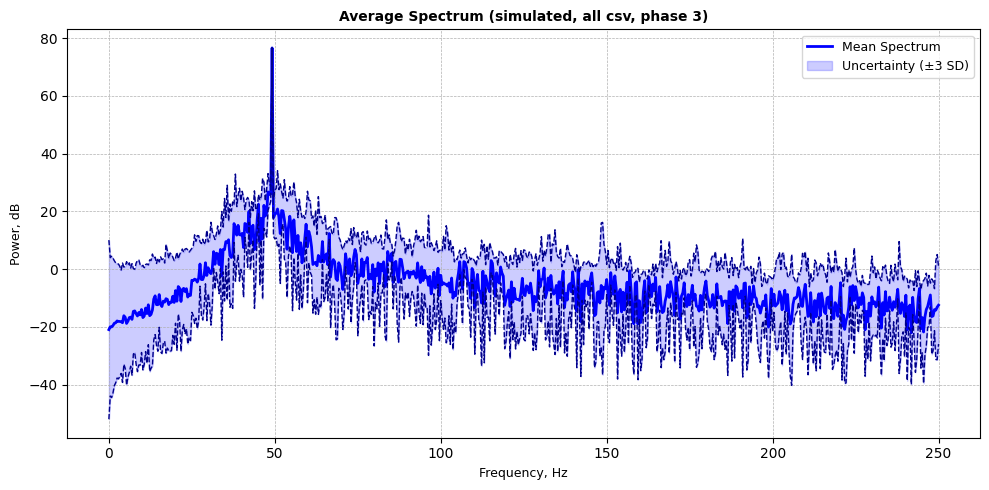

In [13]:
sim_means = {}
sim_std = {}

for phase in range(1, 4):
    sim_means[phase], sim_std[phase] = get_mean_and_std(sim_seg[phase])
    fig, ax = plot_single_segment_with_uncertainty(sim_seg[phase], 
                                                   x_values=sim_freqs[phase], 
                                                   n_std=3, 
                                                   title=f'Average Spectrum (simulated, all csv, phase {phase})',
                                                   inplace=True)

In [ ]:
class Objective:
    def __init__(self, optimized_value: str, low: float = 0, high: float = 50):
        self.optimized_value = optimized_value
        self.low = low
        self.high = high

    def __call__(self, trial: optuna.Trial) -> float:
        Noizz = trial.suggest_float('Noizz', self.low, self.high)
        simulated_files = list(map(str, Path('.\\').glob(f'Noizz*.csv')))
        for sim_file in simulated_files:
            os.remove(sim_file)
        subprocess.run(f'matlab -batch "Noizz = {Noizz}; Find_Best_Noise_Param"')
        simulated_files = list(map(str, Path('.\\').glob(f'Noizz*.csv')))
        simulated_df = pd.DataFrame({'file_path': simulated_files})
        simulated_df['state'] = 'normal'
        simulated_df['load_condition'] = 100
        simulated_df['experiment'] = 'experiment_2'
        simulated_df['phase'] = simulated_df.file_path.apply(get_phase)
        simulated_df['num_observations'] = simulated_df.file_path.apply(get_num_observations)
        simulated_df['measurement_id'] = simulated_df.apply(get_measurement_id, axis=1)
        simulated_df = simulated_df.reset_index(drop=True).set_index('measurement_id')
        sim_seg[1], _, sim_freqs[1] = preprocessing(simulated_df[simulated_df.phase == 1],
                                                    'sim_data_1',
                                                    segment_length=segment_length,
                                                    step=shift,
                                                    f_sampling=f_sampling,
                                                    cutoff_freq=cutoff_freq
                                                    )
        sim_seg[2], _, sim_freqs[2] = preprocessing(simulated_df[simulated_df.phase == 2],
                                                    'sim_data_2',
                                                    segment_length=segment_length,
                                                    step=shift,
                                                    f_sampling=f_sampling,
                                                    cutoff_freq=cutoff_freq
                                                    )
        sim_seg[3], _, sim_freqs[3] = preprocessing(simulated_df[simulated_df.phase == 3],
                                                    'sim_data_3',
                                                    segment_length=segment_length,
                                                    step=shift,
                                                    f_sampling=f_sampling,
                                                    cutoff_freq=cutoff_freq
                                                    )
        all_mae = 0
        for phase in range(1, 4):
            sim_means[phase], sim_std[phase] = get_mean_and_std(sim_seg[phase])
            all_mae += MAE(real_std[phase], sim_std[phase]) if self.optimized_value == 'std' else MAE(real_means[phase], sim_means[phase])
        return all_mae

In [15]:
study_mean = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study_mean.optimize(Objective(optimized_value='mean', high=20), n_trials=100)
best_params_mean = study_mean.best_params
best_score_mean = study_mean.best_value

[I 2025-09-10 19:11:49,040] A new study created in memory with name: no-name-d7182149-65eb-4d25-bf7f-26fa3a83a120
pre-processing: 100%|██████████| 1/1 [00:00<00:00, 16.87it/s]
[I 2025-09-10 19:12:27,118] Trial 0 finished with value: 64.64263725280762 and parameters: {'Noizz': 8.040322860700098}. Best is trial 0 with value: 64.64263725280762.
pre-processing: 100%|██████████| 1/1 [00:00<00:00, 15.17it/s]
[I 2025-09-10 19:13:07,165] Trial 1 finished with value: 36.368839263916016 and parameters: {'Noizz': 0.8643329287131185}. Best is trial 1 with value: 36.368839263916016.
pre-processing: 100%|██████████| 1/1 [00:00<00:00, 15.26it/s]
[I 2025-09-10 19:13:48,592] Trial 2 finished with value: 68.54611206054688 and parameters: {'Noizz': 10.856112125765371}. Best is trial 1 with value: 36.368839263916016.
pre-processing: 100%|██████████| 1/1 [00:00<00:00, 14.82it/s]
[I 2025-09-10 19:14:28,901] Trial 3 finished with value: 48.088236808776855 and parameters: {'Noizz': 2.2381038235935535}. Best i

In [16]:
study_std = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler())
study_std.optimize(Objective(optimized_value='std', high=20), n_trials=100)
best_params_std = study_std.best_params
best_score_std = study_std.best_value

[I 2025-09-10 20:18:48,287] A new study created in memory with name: no-name-15a7bdd3-af97-4d4a-97d0-454855bd2a01
pre-processing: 100%|██████████| 1/1 [00:00<00:00,  9.17it/s]
[I 2025-09-10 20:19:28,271] Trial 0 finished with value: 5.431609272956848 and parameters: {'Noizz': 8.116464312047519}. Best is trial 0 with value: 5.431609272956848.
pre-processing: 100%|██████████| 1/1 [00:00<00:00, 12.90it/s]
[I 2025-09-10 20:20:07,620] Trial 1 finished with value: 5.431021451950073 and parameters: {'Noizz': 14.464943438827975}. Best is trial 1 with value: 5.431021451950073.
pre-processing: 100%|██████████| 1/1 [00:00<00:00, 13.36it/s]
[I 2025-09-10 20:20:49,190] Trial 2 finished with value: 5.406318426132202 and parameters: {'Noizz': 19.779400424960627}. Best is trial 2 with value: 5.406318426132202.
pre-processing: 100%|██████████| 1/1 [00:00<00:00, 12.64it/s]
[I 2025-09-10 20:21:30,554] Trial 3 finished with value: 5.419465661048889 and parameters: {'Noizz': 0.4354636231876641}. Best is tr

In [18]:
with open('best_params.txt', 'w') as ouf:
    ouf.write(f'Mean: {best_params_mean}\nStd: {best_params_std}')

pre-processing: 100%|██████████| 1/1 [00:00<00:00, 11.20it/s]


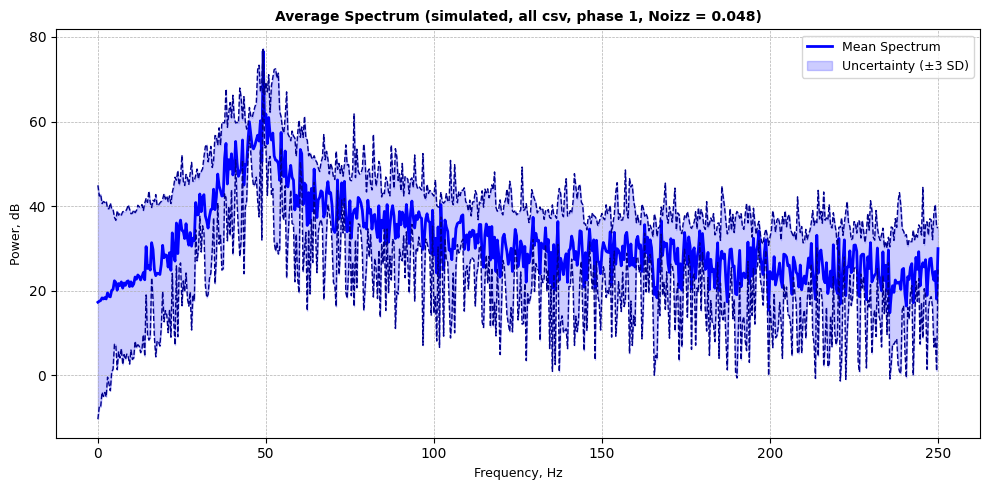

pre-processing: 100%|██████████| 1/1 [00:00<00:00, 14.16it/s]


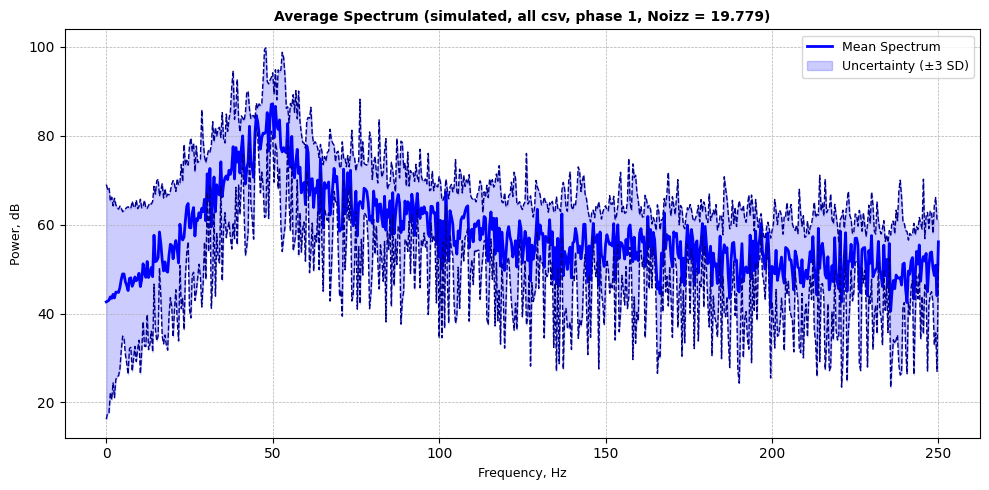

In [ ]:
best_mean_Noizz = round(best_params_mean['Noizz'], 3)
best_std_Noizz = round(best_params_std['Noizz'], 3)

def check_best_params(Noizz):
    subprocess.run(f'matlab -batch "Noizz = {Noizz}; Find_Best_Noise_Param"')
    simulated_files = list(map(str, Path('.\\').glob(f'Noizz{Noizz}*.csv')))
    simulated_df = pd.DataFrame({'file_path': simulated_files})
    simulated_df['state'] = 'normal'
    simulated_df['load_condition'] = 100
    simulated_df['experiment'] = 'experiment_2'
    simulated_df['phase'] = simulated_df.file_path.apply(get_phase)
    simulated_df['num_observations'] = simulated_df.file_path.apply(get_num_observations)
    simulated_df['measurement_id'] = simulated_df.apply(get_measurement_id, axis=1)
    simulated_df = simulated_df.reset_index(drop=True).set_index('measurement_id')
    sim_seg_1, _, sim_freqs_1 = preprocessing(simulated_df[simulated_df.phase == 1],
                                              'sim_data_1',
                                              segment_length=segment_length,
                                              step=shift,
                                              f_sampling=f_sampling,
                                              cutoff_freq=cutoff_freq
                                              )
    fig, ax = plot_single_segment_with_uncertainty(sim_seg_1, 
                                                   x_values=sim_freqs_1, 
                                                   n_std=3, 
                                                   title=f'Average Spectrum (simulated, all csv, phase 1, Noizz = {Noizz})',
                                                   inplace=True)
    
for Noizz in [best_mean_Noizz, best_std_Noizz]:
    check_best_params(Noizz)